# TP01

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Load dataset
df = pd.read_csv('data/ir_static.csv', names=['time', 'voltage'], header=0)
df['time'] = df['time'] - df['time'][0]
df['time'] = df['time'] / 1e9
df = df.set_index('time')

## Visualisation

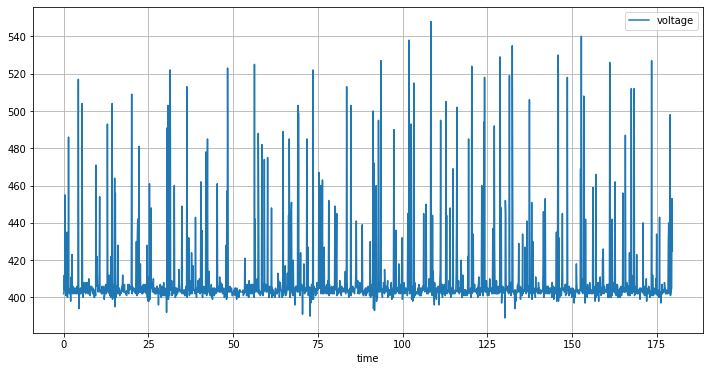

In [3]:
df.plot(figsize=(12,6), grid=True)

## Etude de bruit

In [4]:
# Load dataset
df_steps = pd.read_csv('data/ir_steps.csv', names=['time', 'voltage'], header=0)
df_steps['time'] = df_steps['time'] - df_steps['time'][0]
df_steps['time'] = df_steps['time'] / 1e9
df_steps = df_steps.set_index('time')

In [5]:
df.describe()

,voltage
count,1701.000000
mean,409.557319
std,21.006213
min,389.000000
25%,403.000000
50%,404.000000
75%,405.000000
max,548.000000


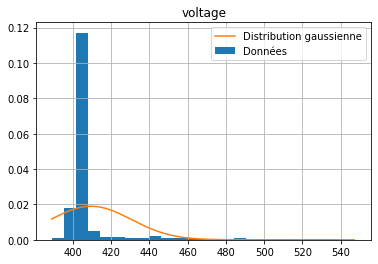

In [6]:
df.hist(bins=25, density=True, label='Données')
x = np.arange(df.min().values, df.max().values, 1)
plt.plot(x, norm.pdf(x, df.mean(), df.std()), label='Distribution gaussienne')
plt.legend()
plt.show()

Propositions de filtrage :
- Fenêtre glissante (mediane)
- Retirer les valeurs aberrantes

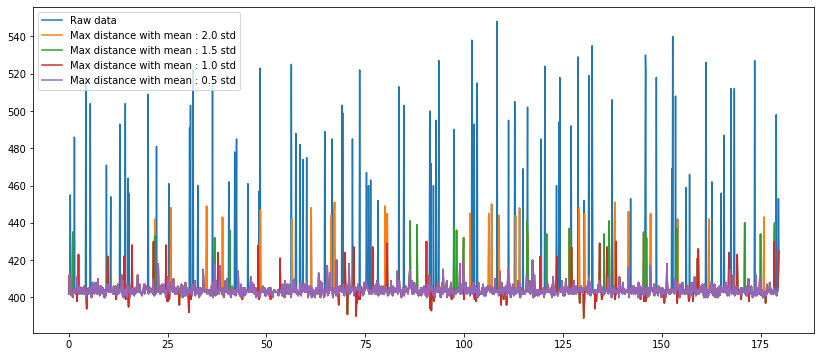

In [7]:
plt.figure(figsize=(14,6))
plt.plot(df, label='Raw data')
for i in np.arange(2, 0, -.5):
    plt.plot(df[(df.voltage- df.voltage.mean()).abs() <  i * df.voltage.std()], label=f'Max distance with mean : {i} std')
    plt.legend()
plt.show()

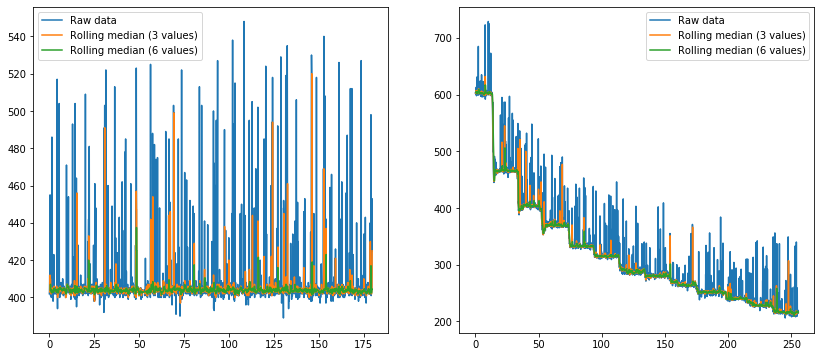

In [8]:
plt.figure(figsize=(14,6))
for i, df_to_plot in enumerate([df, df_steps]):
    plt.subplot(1, 2, 1+i)
    plt.plot(df_to_plot, label='Raw data')
    plt.plot(df_to_plot.rolling(3).median(), label='Rolling median (3 values)')
    plt.plot(df_to_plot.rolling(6).median(), label='Rolling median (6 values)')
    plt.legend()
plt.show()

In [17]:
bins = np.arange(0, 260, 10)
labels = np.arange(30, 155, 5)
df_steps['distance'] = pd.cut(df_steps.index, np.arange(0, 260, 10), labels=labels)
df_steps = df_steps.dropna(how='any')
df_steps['distance'] = df_steps['distance'].astype('int')
df_steps = df_steps[df_steps['distance'] % 10 == 0]

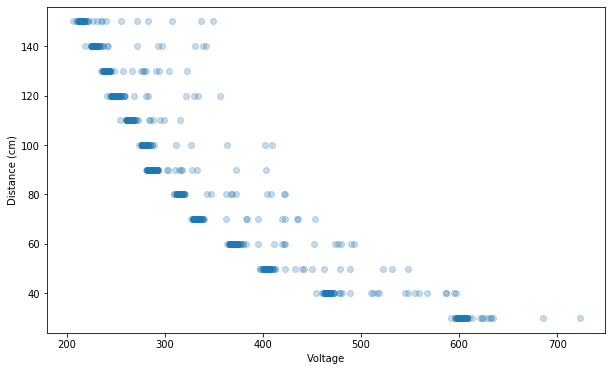

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(df_steps.voltage, df_steps.distance, alpha=0.25)
plt.xlabel('Voltage')
plt.ylabel('Distance (cm)')
plt.show()

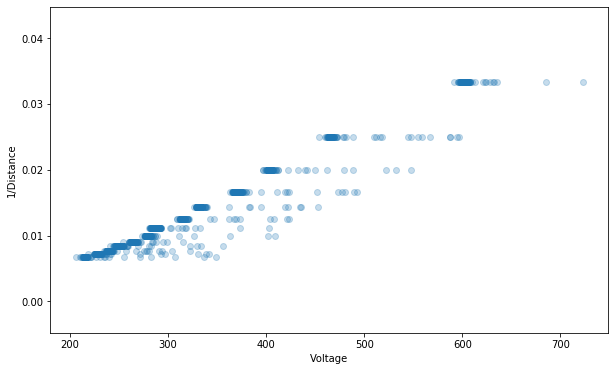

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(df_steps.voltage, 1/df_steps.distance, alpha=0.25)
plt.xlabel('Voltage')
plt.ylabel('1/Distance')
plt.show()

## Model using RANSAC

In [12]:
from sklearn.linear_model import RANSACRegressor

In [13]:
X = df_steps.voltage.values.reshape(-1, 1)
y = 1/df_steps.distance.values.reshape(-1, 1)

In [14]:
regressor = RANSACRegressor()
regressor.fit(X, y)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
                loss='absolute_loss', max_skips=inf, max_trials=100,
                min_samples=None, random_state=None, residual_threshold=None,
                stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [15]:
print(f'1/D = {regressor.estimator_.coef_[0][0]:1.2e} * voltage + {regressor.estimator_.intercept_[0]:1.2e}')

1/D = 7.15e-05 * voltage + -9.54e-03


In [20]:
X_predictions = np.linspace(df_steps.voltage.min(), df_steps.voltage.max()).reshape(-1,1)
y_predictions = regressor.predict(X_predictions)

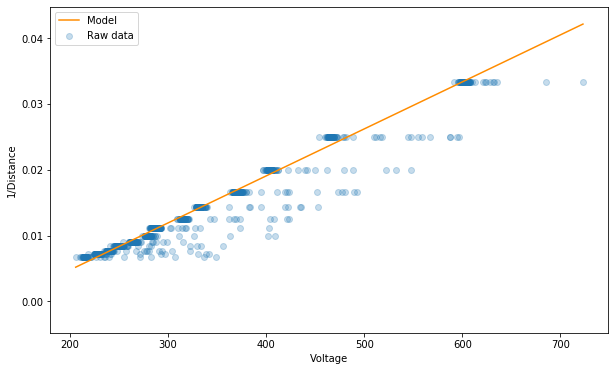

In [21]:
plt.figure(figsize=(10,6))
plt.scatter(df_steps.voltage, 1/df_steps.distance, alpha=0.25, label='Raw data')
plt.plot(X_predictions, y_predictions, label='Model', color='darkorange')
plt.xlabel('Voltage')
plt.ylabel('1/Distance')
plt.legend()
plt.show()

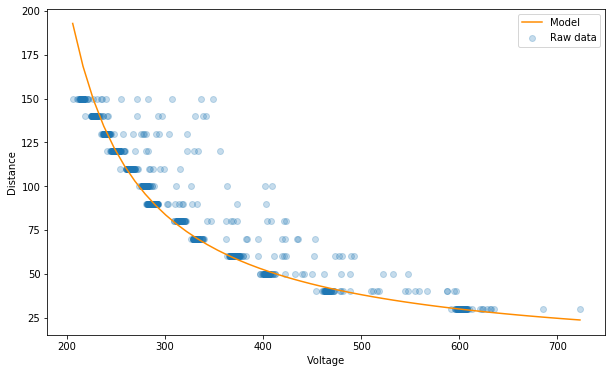

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(df_steps.voltage, df_steps.distance, alpha=0.25, label='Raw data')
plt.plot(X_predictions, 1/y_predictions, label='Model', color='darkorange')
plt.xlabel('Voltage')
plt.ylabel('Distance')
plt.legend()
plt.show()

## Evolution de l'incertitude